In [2]:
import warnings
import numpy as np
from scipy.optimize import minimize_scalar
from sklearn.tree import DecisionTreeRegressor
from pandas import DataFrame, Series
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import pandas as pd
import numpy as np
import dill
import matplotlib.pyplot as plt

In [3]:
def warn(*args, **kwargs):
    pass


warnings.warn = warn

In [4]:
data_train = pd.read_csv('./data_train_target.csv')
data_test = pd.read_csv('./data_test_target.csv')
X_train = data_train.drop(columns=['price'])
X_test = data_test.drop(columns=['price'])
y_train = data_train['price']
y_test = data_test['price']

In [20]:
from time import time


class RandomForestMSE:
    def __init__(
        self, n_estimators, *, max_depth=None, feature_subsample_size=None,
        splitter='best', bootstrap=None, random_state=42, **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.

        splitter: ['best', 'random']
            Criterion for splitting nodes in in trees

        bootstrap: None | int | float
            if None bootstraping is not performed. Otherwise defines splits for bootstraping

        random_state : int
            set the random state for estimators. 42 by default
        """
        self.trees = None

        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.splitter = splitter
        self.random_state = random_state
        self.bootstrap = bootstrap

        # check if feature_subsample_size is in valid range of values
        if isinstance(feature_subsample_size, float) and \
                (feature_subsample_size > 1.0 or feature_subsample_size < 0.0):
            raise ValueError(
                'feature_subsample_size must be in range [0,1] or be integer')
        self.fss = feature_subsample_size if feature_subsample_size is not None else 1/3

        self.tree_parameters = trees_parameters

    def fit(self, X: np.ndarray, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects

        X_val : numpy ndarray
            Array of size n_val_objects, n_features

        y_val : numpy ndarray
            Array of size n_val_objects
        """
        self.trees = []

        # if X or y are not numpy datastructures than redefine them
        if isinstance(X, DataFrame):
            X = X.to_numpy()
        if isinstance(y, Series):
            y = y.to_numpy()

        # generator, used in trees random_state
        rnd_gen = np.random.Generator(np.random.PCG64(self.random_state))

        # check if predefined fss is less than count of features in objects
        if (isinstance(self.fss, int) and self.fss > X.shape[1]):
            raise ValueError(
                'X have less features than expected by feature_subsample_size')

        # if bootstrapping is enabled check and prepare splitting point
        bootstrap = None
        if self.bootstrap is not None:
            if (isinstance(self.bootstrap, int) and self.bootstrap > X.shape[0] or
                    isinstance(self.bootstrap, float) and (self.bootstrap > 1.0 or self.bootstrap < 0)):
                raise ValueError('bootstrap index out of range')
            else:
                bootstrap = self.bootstrap if isinstance(
                    self.bootstrap, int) else round(self.bootstrap * X.shape[0])

        history = None
        if X_val is not None and y_val is not None:
            history = {
                'rmse': {'train': [], 'test': []},
                'r2': {'train': [], 'test': []},
                'mape': {'train': [], 'test': []},
                'mae': {'train': [], 'test': []}
            }

        times = []

        for _ in range(self.n_estimators):
            idx = np.random.permutation(
                X.shape[0])[:bootstrap] if bootstrap is not None else np.arange(X.shape[0])

            # define tree structure
            tree = DecisionTreeRegressor(
                criterion='squared_error',
                splitter=self.splitter,
                max_depth=self.max_depth,
                max_features=self.fss,
                random_state=rnd_gen.integers(0, 100_000_000),
                **self.tree_parameters
            )
            start = time()
            tree.fit(X[idx], y[idx])
            times.append(time() - start)
            self.trees.append(tree)

            if history is not None:
                rmse, mae, r2, mape = self.make_metrics(X, y)
                history['rmse']['train'].append(rmse)
                history['mae']['train'].append(mae)
                history['r2']['train'].append(r2)
                history['mape']['train'].append(mape)

                rmse, mae, r2, mape = self.make_metrics(X_val, y_val)
                history['rmse']['test'].append(rmse)
                history['mae']['test'].append(mae)
                history['r2']['test'].append(r2)
                history['mape']['test'].append(mape)

        return times

    def make_metrics(self, X, y):
        preds = self.predict(X)

        rmse = mean_squared_error(y, preds, squared=False)
        mae = mean_absolute_error(y, preds)
        r2 = r2_score(y, preds)
        mape = mean_absolute_percentage_error(y, preds)

        return rmse, mae, r2, mape

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        # if model is not fitted yet raise error
        if self.trees is None:
            raise ValueError('model is not fited')
        preds = np.array([tree.predict(X) for tree in self.trees])

        return np.mean(preds, axis=0)

In [25]:
times = RandomForestMSE(n_estimators=50, splitter='random').fit(
    X_train, y_train, X_test, y_test)

In [26]:
print(times)

[0.01973867416381836, 0.017017126083374023, 0.016601085662841797, 0.01976490020751953, 0.016557931900024414, 0.016513586044311523, 0.016348838806152344, 0.016314983367919922, 0.015962839126586914, 0.016458988189697266, 0.01718616485595703, 0.017121076583862305, 0.0159912109375, 0.0166471004486084, 0.016956090927124023, 0.01630377769470215, 0.016980886459350586, 0.01626300811767578, 0.01635289192199707, 0.015919208526611328, 0.01704692840576172, 0.0164031982421875, 0.016881942749023438, 0.016477346420288086, 0.016816139221191406, 0.01746511459350586, 0.01667475700378418, 0.01673102378845215, 0.016177892684936523, 0.016056060791015625, 0.016210317611694336, 0.016005992889404297, 0.01688408851623535, 0.016015052795410156, 0.016405105590820312, 0.016430139541625977, 0.017163991928100586, 0.015878915786743164, 0.016157865524291992, 0.01622915267944336, 0.016209125518798828, 0.016035795211791992, 0.015424966812133789, 0.016067981719970703, 0.016416072845458984, 0.016848087310791016, 0.016891

In [28]:
v = []
for i in range(1, 19, 3):
    l = np.array(RandomForestMSE(n_estimators=50, feature_subsample_size=i).fit(
        X_train, y_train, X_test, y_test))
    v.append(l)

In [31]:
means = np.vstack(v).mean(axis=1)
devs = np.vstack(v).std(axis=1)

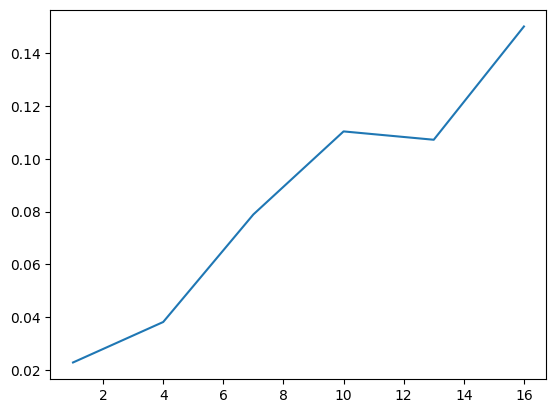

In [32]:
plt.plot([*range(1, 19, 3)], means)

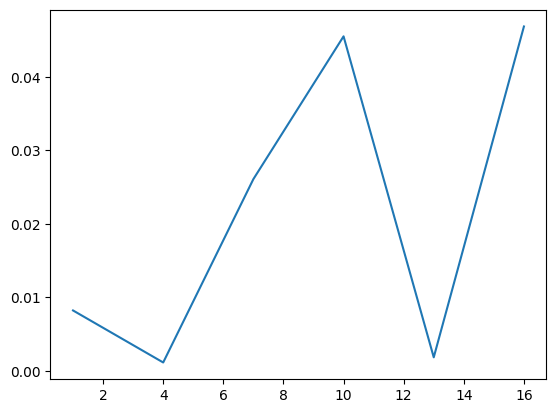

In [33]:
plt.plot([*range(1, 19, 3)], devs)

In [34]:
v = []
for i in range(1, 19, 3):
    l = np.array(RandomForestMSE(n_estimators=50, feature_subsample_size=i, splitter='random').fit(
        X_train, y_train, X_test, y_test))
    v.append(l)

In [35]:
means = np.vstack(v).mean(axis=1)
devs = np.vstack(v).std(axis=1)

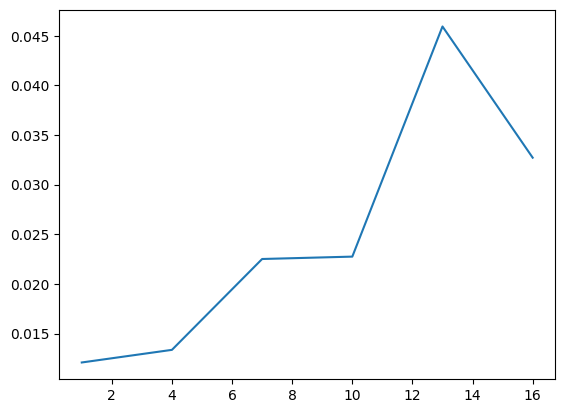

In [36]:
plt.plot([*range(1, 19, 3)], means)

In [37]:
v = []
for i in [3, 5, 9, 15, 20, 30, None]:
    l = np.array(RandomForestMSE(n_estimators=50, max_depth=i).fit(
        X_train, y_train, X_test, y_test))
    v.append(l)

In [38]:
means = np.vstack(v).mean(axis=1)
devs = np.vstack(v).std(axis=1)

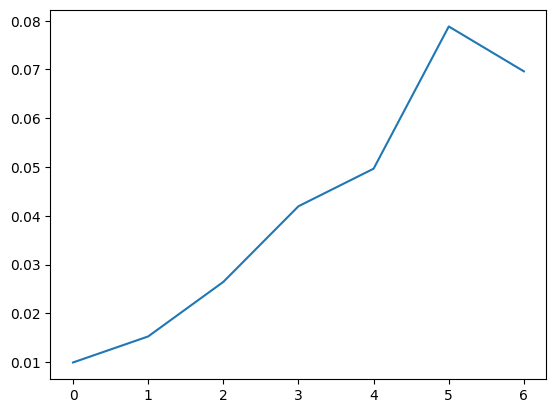

In [40]:
plt.plot([*range(len([3, 5, 9, 15, 20, 30, None]))], means)

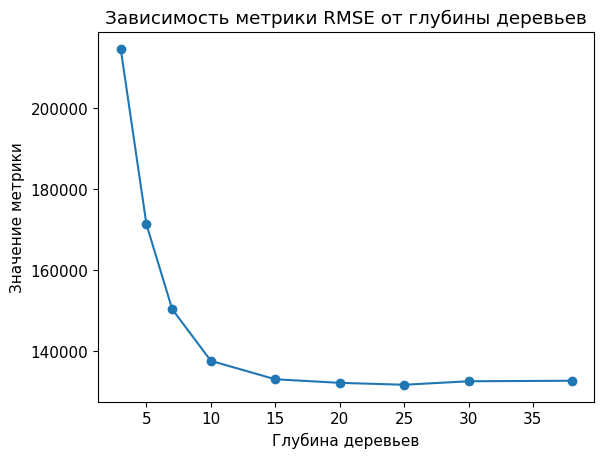

In [70]:
import matplotlib.ticker as ticker
plt.title('Зависимость метрики RMSE от глубины деревьев')
plt.scatter([3, 5, 7, 10, 15, 20, 25, 30, 38, ], t)
plt.plot([3, 5, 7, 10, 15, 20, 25, 30, 38], t)
plt.ylabel('Значение метрики')
plt.xlabel('Глубина деревьев')
plt.savefig('./figures/random-forest-depth_fet.eps',
            format='eps', bbox_inches='tight')

In [ ]:
times = []

In [12]:
from time import time


class GradientBoostingMSE:
    def __init__(
        self, n_estimators, *, learning_rate=0.1, max_depth=5,
        splitter='best', feature_subsample_size=None, random_state=42,
        bootstrap=None,
        **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.

        learning_rate : float
            Use alpha * learning_rate instead of alpha

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float | None
            The size of feature set for each tree. If None then use one-third of all features.


        splitter: ['best', 'random']
            Criterion for splitting nodes in in trees

        bootstrap: None | int | float
            if None bootstraping is not performed. Otherwise defines splits for bootstraping

        random_state : int
            set the random state for estimators. 42 by default
        """
        self.weights = None
        self.trees = None

        self.n_estimators = n_estimators
        self.lr = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.splitter = splitter
        self.bootstrap = bootstrap

        # check if feature_subsample_size is in valid range of values
        if isinstance(feature_subsample_size, float) and \
                (feature_subsample_size > 1.0 or feature_subsample_size < 0.0):
            raise ValueError(
                'feature_subsample_size must be in range [0,1] or be integer')
        self.fss = feature_subsample_size if feature_subsample_size is not None else 1/3
        self.trees_parameters = trees_parameters

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects
        """
        self.weights = []
        self.trees = []

        # if X or y are not numpy datastructures than redefine them
        if isinstance(X, DataFrame):
            X = X.to_numpy()
        if isinstance(y, Series):
            y = y.to_numpy()

        # generator, used in trees random_state
        rnd_gen = np.random.Generator(np.random.PCG64(self.random_state))

        # check if predefined fss is less than count of features in objects
        if (isinstance(self.fss, int) and self.fss > X.shape[1]):
            raise ValueError(
                'X have less features than expected by feature_subsample_size')

        # if bootstrapping is enabled check and prepare splitting point
        bootstrap = None
        if self.bootstrap is not None:
            if (isinstance(self.bootstrap, int) and self.bootstrap > X.shape[0] or
                    isinstance(self.bootstrap, float) and (self.bootstrap > 1.0 or self.bootstrap < 0)):
                raise ValueError('bootstrap index out of range')
            else:
                bootstrap = self.bootstrap if isinstance(
                    self.bootstrap, int) else round(self.bootstrap * X.shape[0])

        history = None
        if X_val is not None and y_val is not None:
            history = {
                'rmse': {'train': [], 'test': []},
                'r2': {'train': [], 'test': []},
                'mape': {'train': [], 'test': []},
                'mae': {'train': [], 'test': []}
            }

        times = []

        # initialize first target for boosting
        grad = y.copy()
        for _ in range(self.n_estimators):
            idx = np.random.permutation(
                X.shape[0])[:bootstrap] if bootstrap is not None else np.arange(X.shape[0])

            tree = DecisionTreeRegressor(
                criterion='squared_error',
                splitter=self.splitter,
                max_features=self.fss,
                random_state=rnd_gen.integers(0, 100_000_000),
                max_depth=self.max_depth,
                **self.trees_parameters
            )
            start = time()
            tree = tree.fit(X[idx], grad[idx])
            times.append(time() - start)
            preds = tree.predict(X)
            alpha = minimize_scalar(fun=lambda a: np.sum(
                (grad - a * preds) ** 2), bounds=(0, 10000)).x

            grad -= self.lr * alpha * preds
            self.trees.append(tree)
            self.weights.append(self.lr * alpha)

            if history is not None:
                rmse, mae, r2, mape = self.make_metrics(X, y)
                history['rmse']['train'].append(rmse)
                history['mae']['train'].append(mae)
                history['r2']['train'].append(r2)
                history['mape']['train'].append(mape)

                rmse, mae, r2, mape = self.make_metrics(X_val, y_val)
                history['rmse']['test'].append(rmse)
                history['mae']['test'].append(mae)
                history['r2']['test'].append(r2)
                history['mape']['test'].append(mape)
        return times

    def make_metrics(self, X, y):
        preds = self.predict(X)

        rmse = mean_squared_error(y, preds, squared=False)
        mae = mean_absolute_error(y, preds)
        r2 = r2_score(y, preds)
        mape = mean_absolute_percentage_error(y, preds)

        return rmse, mae, r2, mape

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        # if model is not fitted yet raise error
        if self.trees is None or self.weights is None:
            raise ValueError('model is not fited')
        preds = np.array([w * tree.predict(X)
                         for w, tree in zip(self.weights, self.trees)])
        return np.sum(preds, axis=0)

In [13]:
v = []
for i in [3, 5, 7, 10, 15, 25, 100]:
    l = GradientBoostingMSE(
        n_estimators=50, max_depth=i, feature_subsample_size=5).fit(X_train, y_train, X_test, y_test)
    v.append(l)

In [14]:
means = np.vstack(v).mean(axis=1)
devs = np.vstack(v).std(axis=1)

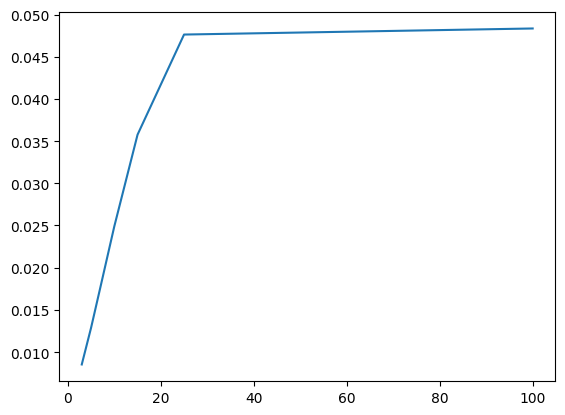

In [16]:
plt.plot(
    [3, 5, 7, 10, 15, 25, 100], means)

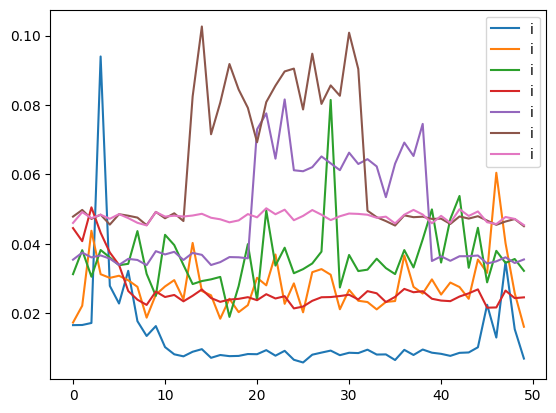

In [20]:
for i in [3, 5, 7, 10, 15, 25, 100]:
    plt.plot(np.arange(50), GradientBoostingMSE(
        n_estimators=50, max_depth=i, feature_subsample_size=5).fit(X_train, y_train, X_test, y_test), label=f'i')
plt.legend()

In [23]:
v = []
for i in [1, 3, 5, 8, 13, 15, 19]:
    l = GradientBoostingMSE(
        n_estimators=50, max_depth=5, feature_subsample_size=i).fit(X_train, y_train, X_test, y_test)
    v.append(l)

In [24]:
means = np.vstack(v).mean(axis=1)
devs = np.vstack(v).std(axis=1)

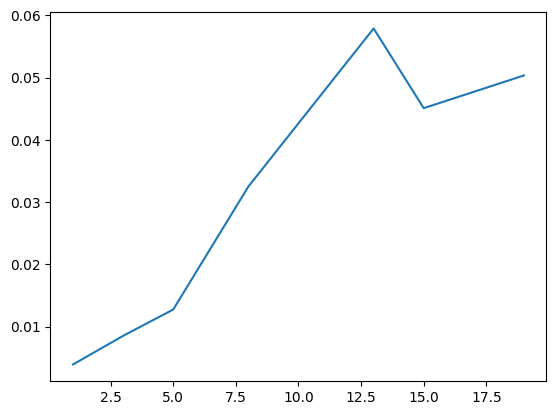

In [26]:
plt.plot(
    [1, 3, 5, 8, 13, 15, 19], means)

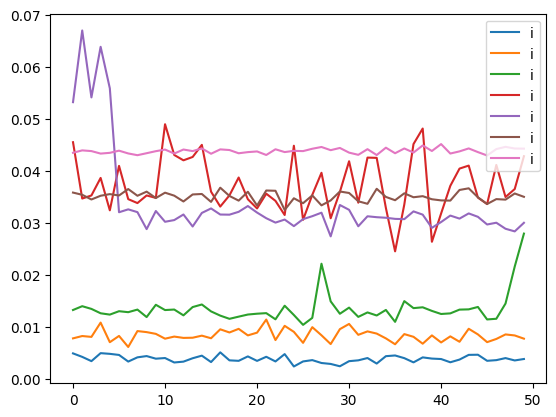

In [27]:
for i in [1, 3, 5, 8, 13, 15, 19]:
    plt.plot(np.arange(50), GradientBoostingMSE(
        n_estimators=50, max_depth=5, feature_subsample_size=i).fit(X_train, y_train, X_test, y_test), label=f'i')
plt.legend()